# Summary:

#### In this notebook, the trial runs from the preceding notebook ('01_So_What.ipynb') are systematically extended to try to find an optimal configuration for the two models, fine tuning the number of units in the network and the number of epochs used in the training schema. 

#### The best performing model configuration will be used in the notebook '03_Blue_in_Green.ipynb' to analyze the impact of adding noise to the clean dataset.


# Table of contents
* [1. Load modules](#Part1_link)
* [2. Setup data](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1  Generate data, separate testing and validation set and standardize testing data](#Part2.1_link)
* [3. Setup models and evaluate for various hyper-parameter choices](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Compile and fit LSTM and RNN model](#Part3.1_link)
* [4. Visualize and save results](#Part4_link)

<a id='Part1_link'></a>
# 1. Load modules

In [1]:
import sys
sys.path.append("../src/")
import Kind_of_Blue  # own class with a collection of methods used in this analysis

import tensorflow as tf

import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

import numpy as np
import pandas as pd


<a id='Part2_link'></a>
# 2. Setup data

<a id='Part2.1_link'></a>
### 2.1 Generate data, separate testing and validation set and standardize testing data

The following steps are repeated from the analysis in the preceding notebook, '01_So_What.ipynb', and are executed in the following step at once for simplicity.

In [2]:
# set a range of dates on which the observations are made
idx = pd.date_range(end='7/1/2020', periods=5*364, freq='d')

# take a sine function as the observations
num_periods = 10  # number of sine periods
observations = [np.sin(2*np.pi*num_periods*x/len(idx)) for x in range(len(idx))]
print('number of observations in time series: {}'.format(len(observations)))

# initialize dataframe to store time series
df = pd.DataFrame(data=observations, columns=['observations'])
df.index = idx

# initialize object
mdq = Kind_of_Blue.Kind_of_Blue()

# load dataframe into object
mdq._selected_features = ['observations']
mdq.df = df

# train-validation split ratio as class attribute set to 70%
print('train split ratio = ', mdq.TRAIN_SPLIT_RATIO)

# initialize dataset from dataframe 
mdq.initialize_dataset()
print('loaded data set length: {}'.format(len(mdq._dataset)))

# standardize data
mdq.standardize_data()

# check that mean equals zero and the standard deviation is one
print('mean: {}, std: {}'.format(round(np.mean(mdq._dataset), 2), round(np.std(mdq._dataset), 2)))

# set number of time points for 1/ future forecasting points and 2/ the past, historical time points
future_target_size = int(365/52)
past_history_size = int(1*365)

# generate train and validation data
mdq.generate_train_and_val_data(future_target_size=future_target_size, past_history_size=past_history_size)

print('number of training samples: {}'.format(mdq._num_samples))

number of observations in time series: 1820
train split ratio =  0.7
loaded data set length: 1820
mean: 0.0, std: 1.0
training set shape: x:(909, 365, 1), y:(909, 7, 1)
validation set shape: x:(174, 365, 1), y:(174, 7, 1)
number of training samples: 909


<a id='Part3_link'></a>
# 3. Setup models and evaluate for various hyper-parameter choices

The models are trained and evaluated under various choices for the number of units and number of epochs.

<a id='Part3.1_link'></a>
### 3.1 Compile and fit models

In [3]:
# generator for configurations to be iterated over

def config_generator():
    
    unit_choices = [64, 128, 256]  # number of units in each neural network layer
    layer_choices = [2]  # total number of layers
    epoch_choices = [10, 30, 50]  # number of epochs the model is trained on
    
    for units in unit_choices:
        for num_layers in layer_choices:
            for epochs in epoch_choices:
                yield units, num_layers, epochs


In [4]:
# iterations over the model parameter configurations are done for both LSTM as well as RNN model
model_types = ['LSTM', 'RNN']

# set number of steps per epoch
num_samples = mdq._num_samples
steps_per_epoch = int(num_samples/future_target_size)
validation_steps = int(steps_per_epoch/2)

# initialize results dictionary
res = {'model_type': [], 'epochs': [], 'num_layers': [], 'units': [], 'val_mse': []
       , 'mse': [], 'total_training_time': []}

for units, num_layers, epochs in config_generator():
    for model_type in model_types:

        print('currently running {} model'.format(model_type))

        # compile model
        mdq.compile_model(units=units, num_layers=num_layers, model_type=model_type)

        # fit model
        mdq.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
                      ,validation_steps=validation_steps, model_type=model_type)
        
        # get errors
        history = mdq._histories[model_type]
        val_mse = history.history['val_mse'][-1]
        mse = history.history['mse'][-1]
        
        # get total training time
        total_training_time = sum(mdq._time_callbacks[model_type].times)
        
        # append results to results dictionary
        res['model_type'].append(model_type)
        res['epochs'].append(epochs)
        res['num_layers'].append(num_layers)
        res['units'].append(units)
        res['val_mse'].append(val_mse)
        res['mse'].append(mse)
        res['total_training_time'].append(total_training_time)


currently running LSTM model
debugLSTM: should an LSTM layer or a Dense layer be added?
Epoch 1/10
129/129 [==============================] - 62s 478ms/step - loss: 0.1651 - mse: 0.1651 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 2/10
129/129 [==============================] - 54s 420ms/step - loss: 0.0322 - mse: 0.0322 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 3/10
129/129 [==============================] - 69s 535ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 4/10
129/129 [==============================] - 62s 484ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 5/10
129/129 [==============================] - 62s 478ms/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/10
129/129 [==============================] - 59s 458ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 7/10
129/129 [==============================] - 60s 465ms/step - loss: 0.0168 - mse: 0.0168 - va

Epoch 9/30
129/129 [==============================] - 14s 107ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 7.9036e-04 - val_mse: 7.9036e-04
Epoch 10/30
129/129 [==============================] - 15s 119ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 9.3797e-04 - val_mse: 9.3797e-04
Epoch 11/30
129/129 [==============================] - 13s 104ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 5.0932e-04 - val_mse: 5.0932e-04
Epoch 12/30
129/129 [==============================] - 13s 99ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 13/30
129/129 [==============================] - 12s 92ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 4.6047e-04 - val_mse: 4.6047e-04
Epoch 14/30
129/129 [==============================] - 12s 89ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 15/30
129/129 [==============================] - 10s 78ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 16/30
129/129 [

129/129 [==============================] - 12s 92ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 47/50
129/129 [==============================] - 12s 91ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 48/50
129/129 [==============================] - 12s 92ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 49/50
129/129 [==============================] - 12s 89ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 50/50
129/129 [==============================] - 12s 91ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0022 - val_mse: 0.0022
currently running LSTM model
debugLSTM: should an LSTM layer or a Dense layer be added?
Epoch 1/10
129/129 [==============================] - 109s 843ms/step - loss: 0.1433 - mse: 0.1433 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 2/10
129/129 [==============================] - 112s 866ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.

129/129 [==============================] - 110s 849ms/step - loss: 0.0074 - mse: 0.0074 - val_loss: 7.3808e-04 - val_mse: 7.3808e-04
Epoch 33/50
129/129 [==============================] - 101s 784ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 34/50
129/129 [==============================] - 105s 812ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 6.9469e-04 - val_mse: 6.9469e-04
Epoch 35/50
129/129 [==============================] - 137s 1s/step - loss: 0.0068 - mse: 0.0068 - val_loss: 8.5808e-04 - val_mse: 8.5808e-04
Epoch 36/50
129/129 [==============================] - 129s 1s/step - loss: 0.0067 - mse: 0.0067 - val_loss: 3.1607e-04 - val_mse: 3.1607e-04
Epoch 37/50
129/129 [==============================] - 119s 924ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 4.6821e-04 - val_mse: 4.6821e-04
Epoch 38/50
129/129 [==============================] - 98s 762ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 39/50
129/129 

Epoch 41/50
129/129 [==============================] - 11s 87ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 42/50
129/129 [==============================] - 12s 90ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 8.1973e-04 - val_mse: 8.1973e-04
Epoch 43/50
129/129 [==============================] - 11s 83ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 44/50
129/129 [==============================] - 11s 84ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 45/50
129/129 [==============================] - 12s 93ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 4.2268e-04 - val_mse: 4.2268e-04
Epoch 46/50
129/129 [==============================] - 11s 86ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 47/50
129/129 [==============================] - 11s 86ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 8.7276e-04 - val_mse: 8.7276e-04
Epoch 48/50
129/129 [==========

Epoch 29/30
129/129 [==============================] - 347s 3s/step - loss: 0.0035 - mse: 0.0035 - val_loss: 1.7349e-04 - val_mse: 1.7349e-04
Epoch 30/30
129/129 [==============================] - 364s 3s/step - loss: 0.0036 - mse: 0.0036 - val_loss: 1.8785e-04 - val_mse: 1.8785e-04
currently running RNN model
Epoch 1/30
129/129 [==============================] - 45s 348ms/step - loss: 0.3107 - mse: 0.3107 - val_loss: 0.0955 - val_mse: 0.0955
Epoch 2/30
129/129 [==============================] - 45s 349ms/step - loss: 0.0733 - mse: 0.0733 - val_loss: 0.0706 - val_mse: 0.0706
Epoch 3/30
129/129 [==============================] - 45s 348ms/step - loss: 0.1439 - mse: 0.1439 - val_loss: 0.0524 - val_mse: 0.0524
Epoch 4/30
129/129 [==============================] - 43s 333ms/step - loss: 0.1390 - mse: 0.1390 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 5/30
129/129 [==============================] - 46s 356ms/step - loss: 0.0429 - mse: 0.0429 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 6/30
12

129/129 [==============================] - 369s 3s/step - loss: 0.0043 - mse: 0.0043 - val_loss: 7.7533e-04 - val_mse: 7.7533e-04
Epoch 29/50
129/129 [==============================] - 350s 3s/step - loss: 0.0036 - mse: 0.0036 - val_loss: 2.0577e-04 - val_mse: 2.0577e-04
Epoch 30/50
129/129 [==============================] - 373s 3s/step - loss: 0.0038 - mse: 0.0038 - val_loss: 3.3302e-04 - val_mse: 3.3302e-04
Epoch 31/50
129/129 [==============================] - 403s 3s/step - loss: 0.0039 - mse: 0.0039 - val_loss: 3.9585e-04 - val_mse: 3.9585e-04
Epoch 32/50
129/129 [==============================] - 358s 3s/step - loss: 0.0040 - mse: 0.0040 - val_loss: 8.8640e-04 - val_mse: 8.8640e-04
Epoch 33/50
129/129 [==============================] - 368s 3s/step - loss: 0.0035 - mse: 0.0035 - val_loss: 4.3229e-04 - val_mse: 4.3229e-04
Epoch 34/50
129/129 [==============================] - 354s 3s/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 35/50
129/129 [=====

<a id='Part4_link'></a>
# 4. Visualize and save results

The results are stored locally in a .csv file and the model performance as a function of number of units and epochs plotted.

In [5]:
# transform dictionary to dataframe
df_res = pd.DataFrame(res)

# store dataframe as csv locally
df_res.to_csv('../data/02_results.csv')

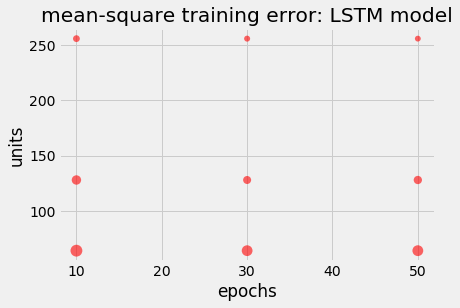

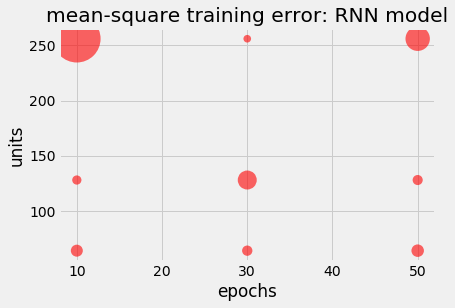

In [6]:
# visualize results; use bubble plots to indicate magnitude of mean-square error for specific configuration comparing
# RNN to LSTM results

x_label = 'epochs'
y_label = 'units'
z_label = 'mse'

for model_type in model_types:
    condition_1 = (df_res['model_type']== model_type)
    
    x = df_res[condition_1][x_label].values
    y = df_res[condition_1][y_label].values
    
    z = df_res[condition_1][z_label].values
    plt.scatter(x, y, s=z*10000, alpha=0.6, c="red", linewidth=0.0)
        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('mean-square training error: {} model'.format(model_type))
    plt.show()